WRF RESULTS PROCESSING: WRFOUT_D01

The following script takes as an input the output file (wrfout_d01*) from a wrf real run, and produces
plots that demonstrate key indicators of its performance in simulating a cyclone (for a single given time-slice).
The script is designed to work when wrfout_d01.nc contains muliplte times per file; i.e. it uses the
argument "timeidx=wrf.ALL_TIMES" when fetching/calculating variables.  If your wrfout_d01 files contain only a single
time, then you may have to alter the code.  If the file is too large and you hit memory errors, then try using the
provided .py (plot_wrfout_static.py) version of this file in a HPC environment. The script produces plots of:

        Sea-level pressure & 10m windspeed
        Geopotential (gph) height and winds at the gph, including wind direction
        Cloud-top temperatures & vertical cross section of windspeeds through the eye of the cyclone
        Absolute vorticity
        Maximum wind speeds - including timeseries for four towns/cities at given locations.

The user needs to go to the 'user inputs' section and enter all the information required. To help with
creating the vertical cross section through the eye of the TC, follow the instructions below to create
a file containing the path of the modelled cyclone. This is used to automate the location of the
cross-section in the subsequent script:

    When automatic moving nest is employed in the WRF-real runs, the model dumps the vortex center
    location, with minimum mean sea-level pressure and maximum 10 m winds in standard out
    file (e.g. rsl.out.0000). Typing:

    grep ATCF rsl.out.0000 > ATCF_track.txt 

    Will produce a list of storm information at 15 minutes intervals and dump them into a text file.
    Manually convert the text file into a .csv for easy importing.

This script requires the installation of the wrf-python library (among others)

    pip install --user wrf-python
 
This script is written in Jan. 2019 by Chad Burton.
The notebook was completed as a part of a graduate program at Geoscience Australia.

### Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import cartopy
import pandas as pd
import wrf
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import COLORS
from cartopy.feature import NaturalEarthFeature
from wrf import to_np, getvar, smooth2d, GeoBounds, get_cartopy, cartopy_xlim
from wrf import cartopy_ylim, latlon_coords, get_basemap, interplevel, CoordPair
from wrf import vertcross, xy_to_ll, ll_to_xy
import geopandas as gpd
from matplotlib import gridspec

## User Input

Enter the required user inputs and then run all the cells below to produce the desired plots

In [51]:
#where is the data (ie wrfout_d0*)?
ncfile_path = "data/standard_runs/alby_staticD02_3dom_0204_1200/wrfout_d01_1978-04-02_12:00:00"
#which time slice do you want (FORMAT MUST BE: '1978-04-05T00:00') 
time = '1978-04-04T18:00'

#what pressure (in hPa) do you wish to see the geopoential height, windspeed and vorticity?
gph_pressure = 500

#for the cross-section through the cyclone, enter the filepath of the .csv that contains the vortex tracking TC path 
TC_modelled_path_loc = 'data/standard_runs/alby_staticD02_3dom_0204_1200/ATCF_alby_staticD02_3dom_0204_1200.csv'
#enter the width of the desired cross-section in grid units (better if this is an even number, 20 is about right)
width = 20
#----------

####################
#Maximum Wind speeds
####################

#Do you want a facet plot of maximum wind speeds?
maxWindSpeeds = True
 
#Enter FOUR (must be four) timeslices to plot up as a list (FORMAT MUST BE: '1978-04-05T00:00') 
times_ws = ['1978-04-04T12:00', '1978-04-04T15:00', '1978-04-04T18:00', '1978-04-04T21:00']

#Do you want max wind speed timeseries plots for individual towns/cities?
ts_plots = True
# If 'True' above, enter the names of FOUR towns and locations (MUST BE FOUR)
cities= ['Geraldton', 'Perth Airport', 'Bunbury', 'Albany']
city_lats = [-28.795, -31.927,  -33.374, -34.941]
city_longs = [114.697, 115.976, 115.683, 117.802]

# If you have station data that you want plotted on the timeseries plots for comparison, then set 
# 'add_station_data' to True, but be careful, this only works because I curated the station data for
# my specific purposes so ordinarly you should set this to false
add_station_data = True
stationID = [8051, 9021, 9021, 9741]

#------------
# Should I export the results and where?
export = True
results_path = "results/standard_runs/alby_staticD02_3dom_0204_1200/"

##  Useful things for the script

In [40]:
####################
#getting time data from a variable to use for labelling plots
#This means the user can enter a time of interest rather
#than an index integer - more intuitive.
####################
time_slp = time
time_gph = time
time_vert = time
time_vort = time

    #grabbing any variable that will load reasaonably quickly
ncfile = netCDF4.Dataset(ncfile_path)
p = getvar(ncfile, "pressure", timeidx=wrf.ALL_TIMES, method="cat")

#getting the time dimension
times=[]
for i in range(0, len(p.Time)):
    x = str(p.Time[i].values)[:16]
    times.append(x)

#convert the time strings into indexes for slicing later
time_slice_1 = times.index(time_slp)
time_slice_2 = times.index(time_gph)
time_slice_3 = times.index(time_vert)
time_slice_4 = times.index(time_vort)

##########################
#Automating the location of the cross-section
#########################
def XsectionCoords(filepath, time, width):
    """
    A function for calculating the grid coords for a x-section through the
    eye of a TC using only a user specified time-stamp and the desired width of
    the x-section (in grid units)
    """
    #bring in the data
    model_path = pd.read_csv(filepath, header=None, names=["NAME", "datetime", "lat", "long", "Pcentre", "MaxWind"])
    #a little loop to make the time string match those from the vortex tracking data
    x=[]
    for i in range(0, len(model_path['datetime'])):
        b = model_path['datetime'][i][:16]
        b = b.replace("_", "T")
        x.append(b)
    model_path['datetime'] = x

    #index out the time that the user wants for the cross-section
    a = model_path[model_path['datetime'] == time]
    lat_vert = a['lat']
    long_vert = a['long']

    #convert the lat long to i,j coords
    i = int(ll_to_xy(netCDF4.Dataset(ncfile_path), lat_vert, long_vert)[0])
    j = int(ll_to_xy(netCDF4.Dataset(ncfile_path), lat_vert, long_vert)[1])
    #create the dimensions of the cross-section based on user specified width
    i_west= int(i-(width/2))
    i_east= int(i+(width/2))
    j_east=j
    j_west=j
    
    return i_west, i_east, j_west, j_east

i_west, i_east, j_west, j_east = XsectionCoords(TC_modelled_path_loc, time_vert, width)


## Sea Level Pressure & 10m Wind Speed

In [41]:
#Create sea level pressure and plot sea level pressure for a time slice
ncfile = netCDF4.Dataset(ncfile_path)
# Get the Sea Level Pressure
slp = wrf.getvar(ncfile, "slp", timeidx=wrf.ALL_TIMES, method="cat")
slp = slp[time_slice_1]
# Smooth the sea level pressure since it tends to be noisy near the mountains
smooth_slp = smooth2d(slp, 3)

#get wind speed and components
wspd = getvar(ncfile, "uvmet10_wspd_wdir", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]
wspd = wspd[time_slice_1]

u10 = getvar(ncfile, "uvmet10", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]
u10 = u10[time_slice_1]

v10 = getvar(ncfile, "uvmet10", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[1,:]
v10 = v10[time_slice_1]


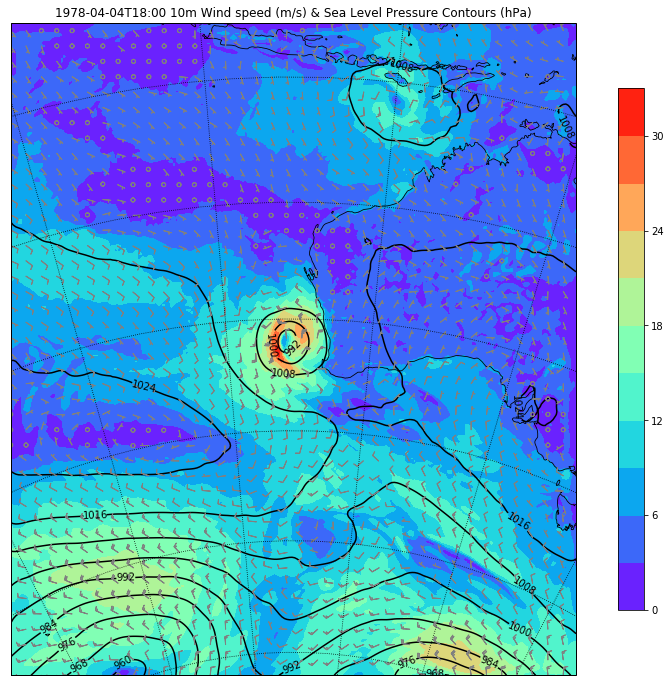

In [42]:
# Get the latitude and longitude points
lats, lons = latlon_coords(slp)
# Get the cartopy mapping object
cart_proj = get_cartopy(slp)
# Create a figure
fig = plt.figure(figsize=(15,12))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)
# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)


# Make the contour outlines for the smoothed sea level pressure.
contours = plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black",
            transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")
# Add the wind speed contours
plt.contourf(to_np(lons), to_np(lats), to_np(wspd), 10, transform=crs.PlateCarree(),
             cmap=get_cmap("rainbow"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.8)

#Add wind barbs, only plotting every 15th data point.
barbNo=6
ax.barbs(to_np(lons[::barbNo,::barbNo]), to_np(lats[::barbNo,::barbNo]),
         to_np(u10[::barbNo,::barbNo]),to_np(v10[::barbNo,::barbNo]), sizes=dict(emptybarb=0.25, spacing=0.2, height=0.5),
         transform=crs.PlateCarree(), barbcolor='grey', length=4, zorder=2)

# Set the map limits
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))
# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(time_slp + " " + "10m Wind speed (m/s) & Sea Level Pressure Contours (hPa)")

if export == True:
    plt.savefig(results_path + "10mWS_SLP_" + time_slp + ".pdf", bbox_inches='tight')

## Geopotential Height and Wind Speed

In [43]:
# Extract the pressure, geopotential height, and wind variables
ncfile = netCDF4.Dataset(ncfile_path)

p = getvar(ncfile, "pressure", timeidx=wrf.ALL_TIMES, method="cat")
z = getvar(ncfile, "z", timeidx=wrf.ALL_TIMES, method="cat")
ua = getvar(ncfile, "ua", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
va = getvar(ncfile, "va", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
wspd = getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]

# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z[time_slice_2], p[time_slice_2], gph_pressure)
u_500 = interplevel(ua[time_slice_2], p[time_slice_2], gph_pressure)
v_500 = interplevel(va[time_slice_2], p[time_slice_2], gph_pressure)
wspd_500 = interplevel(wspd[time_slice_2], p[time_slice_2], gph_pressure)

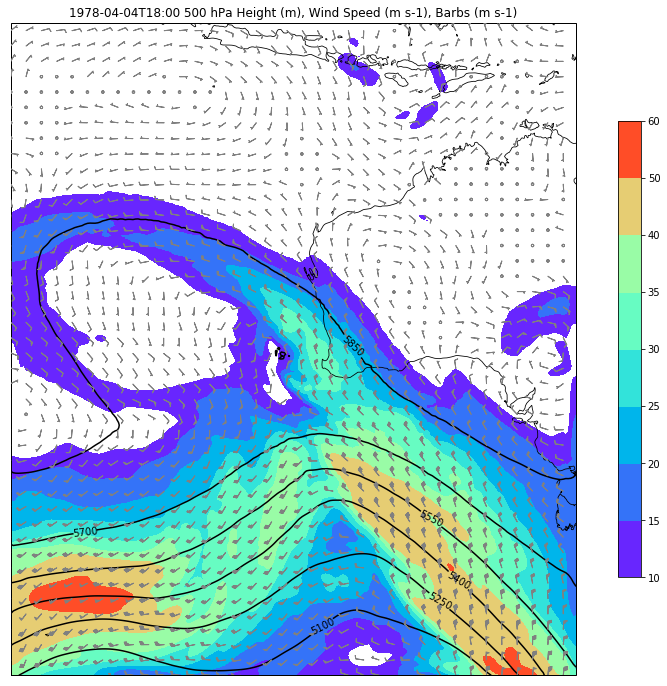

In [44]:
# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the basemap object
cart_proj = get_cartopy(ht_500)

# Create the figure
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection=cart_proj)

# Add the 500 hPa geopotential height contours
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500), colors="black", transform=crs.PlateCarree())
ax.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [10, 15, 20, 25, 30, 35, 40, 50, 60]
wspd_contours = ax.contourf(to_np(lons), to_np(lats), to_np(wspd_500), levels=levels,
                            cmap=get_cmap("rainbow"), transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax, pad=.05, shrink=0.7)

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa wind barbs, only plotting every nth data point.
barbNo=6
ax.barbs(to_np(lons[::barbNo,::barbNo]), to_np(lats[::barbNo,::barbNo]), to_np(u_500[::barbNo, ::barbNo]),
         to_np(v_500[::barbNo, ::barbNo]), transform=crs.PlateCarree(), length=4, barbcolor='grey', zorder=3)

# Set the map limits
ax.set_xlim(cartopy_xlim(ht_500))
ax.set_ylim(cartopy_ylim(ht_500))

plt.title(time_gph + " " + str(gph_pressure) + " hPa Height (m), Wind Speed (m s-1), Barbs (m s-1)")

if export == True:
    plt.savefig(results_path + "GeoPotHeight_Windspeed_" + time_gph + ".pdf", bbox_inches='tight')

## Cloud Top Temp and X-section

Splitting the data calculation from the plotting because the data takes a long time to compute

In [45]:
ncfile = netCDF4.Dataset(ncfile_path)

# Get the WRF variables
slp = getvar(ncfile, "slp", timeidx=wrf.ALL_TIMES, method="cat")
slp=slp[time_slice_3]
smooth_slp = smooth2d(slp, 3)
ctt = getvar(ncfile, "ctt", timeidx=wrf.ALL_TIMES, method="cat")
ctt = ctt[time_slice_3]
z = getvar(ncfile, "z", timeidx=wrf.ALL_TIMES, method="cat")
z=z[time_slice_3]
dbz = getvar(ncfile, "dbz", timeidx=wrf.ALL_TIMES, method="cat")
dbz = dbz[time_slice_3]
Z = 10**(dbz/10.)
wspd =  getvar(ncfile, "wspd_wdir", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")[0,:]
wspd = wspd[time_slice_3]

# Create the start point and end point for the cross section
lat_lon_west = xy_to_ll(ncfile, i_west, j_west)
lat_lon_east = xy_to_ll(ncfile, i_east, j_east)
lat_west, lon_west, lat_east, lon_east =  float(lat_lon_west[0]), float(lat_lon_west[1]),float(lat_lon_east[0]), float(lat_lon_east[1])                                      
start_point = CoordPair(lat=lat_west , lon= lon_west)
end_point = CoordPair(lat= lat_east , lon= lon_east)

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points
# along the cross-section in the metadata by setting latlon to True.
z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point, end_point=end_point,
                    latlon=True, meta=True)
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point, end_point=end_point,
                       latlon=True, meta=True)
dbz_cross = 10.0 * np.log10(z_cross)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


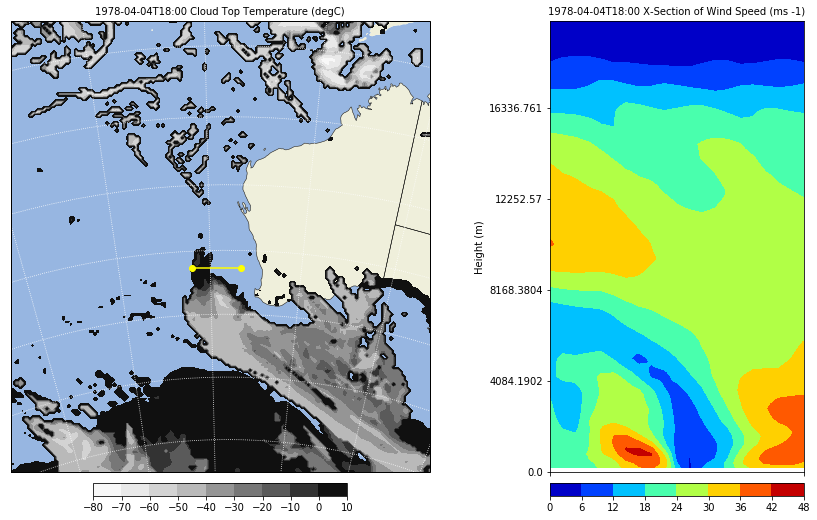

In [46]:
# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy projection object
cart_proj = get_cartopy(slp)

# Create the figure 3 subplots
from matplotlib import gridspec
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.5])
ax_ctt = fig.add_subplot(gs[0], projection = cart_proj)
ax_wspd = fig.add_subplot(gs[1])

# Make the pressure contours
contour_levels = [960, 965, 970, 975, 980, 990, 995, 1000, 1005]
c1 = ax_ctt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), levels=contour_levels, colors="white",
                zorder=3, linewidths=1.0)

# Create the filled cloud top temperature contours
contour_levels = [-80.0, -70.0, -60, -50, -40, -30, -20, -10, 0, 10]
ctt_contours = ax_ctt.contourf(to_np(lons), to_np(lats), to_np(ctt), contour_levels, cmap=get_cmap("Greys"),
                           transform=crs.PlateCarree(), zorder=2)

ax_ctt.plot([start_point.lon, end_point.lon],
            [start_point.lat, end_point.lat], color="yellow", marker="o",
            transform=crs.PlateCarree(), zorder=3)

# Create the color bar for cloud top temperature
cb_ctt = fig.colorbar(ctt_contours, ax=ax_ctt, shrink=0.5, orientation="horizontal", pad=0.02)
cb_ctt.ax.tick_params(labelsize=10)

# Draw the oceans, land, and states
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
land = NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=COLORS['land'])
ocean = NaturalEarthFeature(category='physical', name='ocean',scale='50m',
                                     facecolor=COLORS['water'])
ax_ctt.add_feature(ocean)
ax_ctt.add_feature(land)
ax_ctt.add_feature(states, linewidth=.5, edgecolor="black")

#crop the domain
hur_bounds = GeoBounds(CoordPair(lat=(np.amin(to_np(lats)+15)), lon=(np.amin(to_np(lons))+15)),
                       CoordPair(lat=(np.amax(to_np(lats))-5), lon=(np.amax(to_np(lons))-30)))
ax_ctt.set_xlim(cartopy_xlim(ctt, geobounds=hur_bounds))
ax_ctt.set_ylim(cartopy_ylim(ctt, geobounds=hur_bounds))
ax_ctt.gridlines(color="white", linestyle="dotted")

# Make the contour plot for wspd
wspd_contours = ax_wspd.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))
# Add the color bar
cb_wspd = fig.colorbar(wspd_contours, ax=ax_wspd, shrink=1, orientation="horizontal", pad=0.02)
cb_wspd.ax.tick_params(labelsize=10)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
ax_wspd.set_xticks(x_ticks[::20])
ax_wspd.set_xticklabels([], rotation=45)

# Set the y-ticks to be height.
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax_wspd.set_yticks(v_ticks[::20])
ax_wspd.set_yticklabels(vert_vals[::20], fontsize=10)
ax_wspd.set_ylabel("Height (m)", fontsize=10)

# Add titles
ax_ctt.set_title(time_vert + " Cloud Top Temperature (degC)", {"fontsize" : 10})
ax_wspd.set_title(time_vert + " X-Section of Wind Speed (ms -1)", {"fontsize" : 10})

if export == True:
    plt.savefig(results_path + "CTT_VertWS_" + str(time_vert) + ".pdf", bbox_inches='tight')

## Storm Vorticity

In [47]:
ncfile = netCDF4.Dataset(ncfile_path)
#extract absolute vorticity
avo = getvar(ncfile, "avo", timeidx=wrf.ALL_TIMES, method="cat")
avo = avo[time_slice_4]
# Extract the Pressure (hPa) fields
p = getvar(ncfile, "pressure", timeidx=wrf.ALL_TIMES, method="cat")
p = p[time_slice_4]
#extract height
z = getvar(ncfile, "z", timeidx=wrf.ALL_TIMES, method="cat")
z = z[time_slice_4]
#wind components
ua = getvar(ncfile, "ua", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
ua = ua[time_slice_4]
va = getvar(ncfile, "va", units="m s-1", timeidx=wrf.ALL_TIMES, method="cat")
va= va[time_slice_4]

# Compute the absolute vorticity, u, v, and gph at 500hPa
avo_500 = interplevel(avo, p, gph_pressure)
ht_500 = interplevel(z, p, gph_pressure)
u_500 = interplevel(ua, p, gph_pressure)
v_500 = interplevel(va, p, gph_pressure)

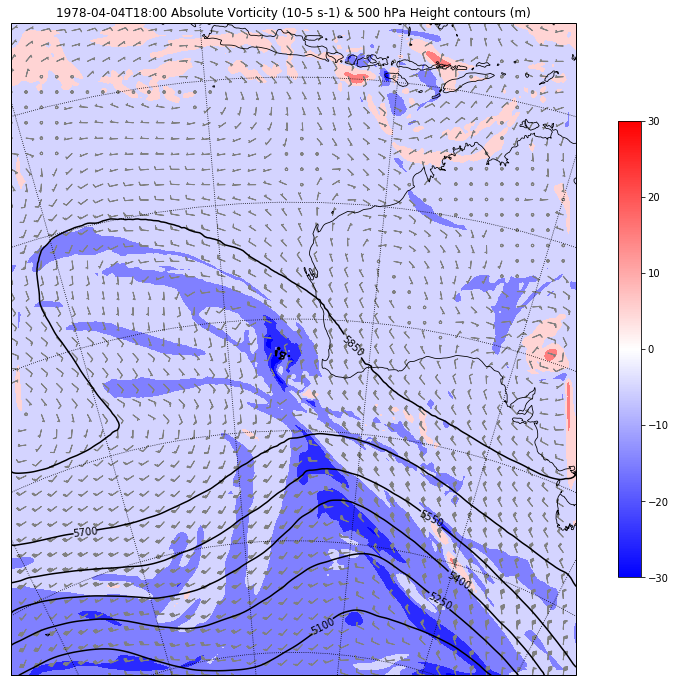

In [48]:
# Get the latitude and longitude points
lats, lons = latlon_coords(avo_500)
# Get the cartopy mapping object
cart_proj = get_cartopy(avo_500)
# Create a figure
fig = plt.figure(figsize=(15,12))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)
# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500), colors="black",
            transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the vorticity
plt.contourf(to_np(lons), to_np(lats), to_np(avo_500), transform=crs.PlateCarree(),
             cmap=get_cmap("bwr"), vmin=-30, vmax=30)

#create a colorbar
sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-30, vmax=30))
sm._A = []
plt.colorbar(sm, shrink=0.7)

# Add the 500 hPa wind barbs, only plotting every 25th data point.
barbNo=6
plt.barbs(to_np(lons[::barbNo,::barbNo]), to_np(lats[::barbNo,::barbNo]), to_np(u_500[::barbNo, ::barbNo]),
         to_np(v_500[::barbNo, ::barbNo]), transform=crs.PlateCarree(), length=4,barbcolor='grey')

# Set the map limits
ax.set_xlim(cartopy_xlim(avo_500))
ax.set_ylim(cartopy_ylim(avo_500))
# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")
plt.title(time_vort + " " + "Absolute Vorticity (10-5 s-1) & " + str(gph_pressure) + " hPa Height contours (m)")

if export == True:
    plt.savefig(results_path + "absolute_vorticity_" + time_vort + ".pdf", bbox_inches='tight')

## Maximum 10m wind speeds

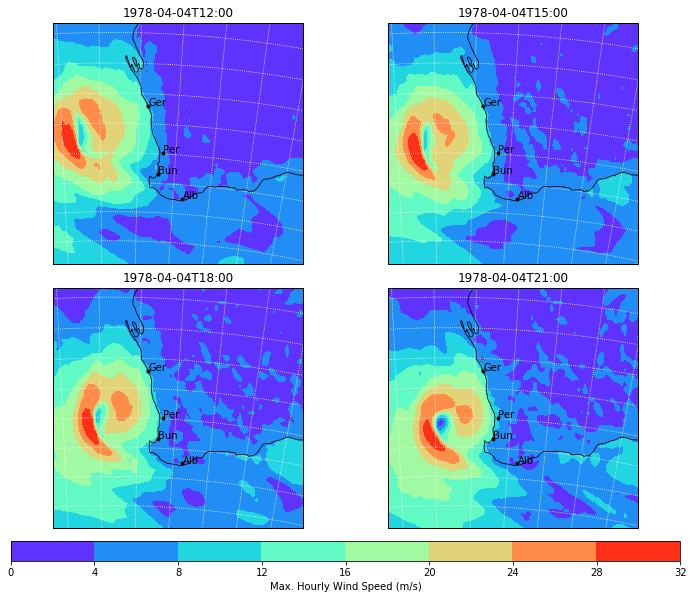

In [52]:
if maxWindSpeeds == True:
    
    ncfile = netCDF4.Dataset(ncfile_path)
    max10ws = wrf.getvar(ncfile, "WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")

    #convert the time strings into indexes for slicing later
    t1, t2, t3, t4 = times.index(times_ws[0]), times.index(times_ws[1]), times.index(times_ws[2]), times.index(times_ws[3])
    times_slice_ws = [t1,t2,t3,t4]

    # Get the lat/lon points
    lats, lons = latlon_coords(max10ws)

    # Get the cartopy projection object
    cart_proj = get_cartopy(max10ws)

    #create a figure and projected subplots
    fig = plt.figure(figsize=(12,9))
    ax_ws1 = fig.add_subplot(221, projection=cart_proj)
    ax_ws2 = fig.add_subplot(222, projection=cart_proj)
    ax_ws3 = fig.add_subplot(223, projection=cart_proj)
    ax_ws4 = fig.add_subplot(224, projection=cart_proj)

    #add the subplot axes to a list to iterate over
    axes= [ax_ws1, ax_ws2, ax_ws3, ax_ws4]

    #extent of maps to be plotted
    sw_region = GeoBounds(CoordPair(lat=-39.45, lon=106.63),
                          CoordPair(lat=-22.35, lon=125.29))
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                 name='admin_1_states_provinces_shp')
    
    #add data series to a list iterable
    data_series = [max10ws[t1], max10ws[t2], max10ws[t3], max10ws[t4]]

    for ax, data, in zip(axes, data_series):
        p = ax.contourf(to_np(lons), to_np(lats), to_np(data),
                    transform=crs.PlateCarree(), cmap=get_cmap("rainbow"), zorder=2)
        ax.add_feature(states, linewidth=.5, zorder=3)
        ax.coastlines('50m', linewidth=0.8, zorder=3)
        ax.set_xlim(cartopy_xlim(max10ws, geobounds=sw_region))
        ax.set_ylim(cartopy_ylim(max10ws, geobounds=sw_region))
        ax.gridlines(color="white", linestyle="dotted")
        ax.scatter(city_longs, city_lats, c ='black', marker= '.', transform=crs.PlateCarree(), zorder =3)
        transform = crs.PlateCarree()._as_mpl_transform(ax) #this is a work-around to transform xy coords in ax.annotate
        if ts_plots == True:
            for i, txt in enumerate(cities):
                ax.annotate(txt[:3], (city_longs[i], city_lats[i]), xycoords=transform)
        ax.set_title(str(data.Time.values)[:16], size=12)

    # Add a color bar
    plt.subplots_adjust(bottom=0.10, hspace=0.10, wspace=0.001)
    p0 = axes[2].get_position().get_points().flatten()
    p1 = axes[3].get_position().get_points().flatten()
    ax_cbar = fig.add_axes([p0[0], 0.05, p1[2]-p0[0], 0.03])
    cb = plt.colorbar(p, cax=ax_cbar, orientation='horizontal')
    cb.set_label("Max. Hourly Wind Speed (m/s)", rotation=0)

    plt.savefig(results_path + "max10ws" + ".pdf", bbox='tight')

### Time series for locations

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


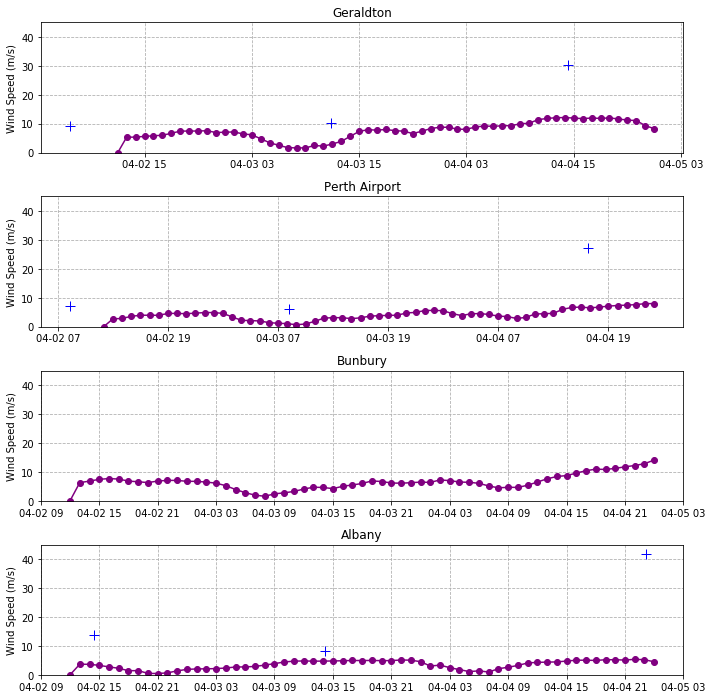

In [53]:
if (maxWindSpeeds == True and ts_plots == True):
    #convert lat longs into xy's
    xys=ll_to_xy(ncfile,city_lats, city_longs)
    x_s = list(xys.values[0])
    y_s = list(xys.values[1])

    #create figure
    fig = plt.figure(figsize=(10,12))
    ax_p1 = fig.add_subplot(511)
    ax_p2 = fig.add_subplot(512)
    ax_p3 = fig.add_subplot(513)
    ax_p4 = fig.add_subplot(514)

    #add axes into an iterable
    axes= [ax_p1, ax_p2, ax_p3, ax_p4]
    
    if add_station_data == True:
            dtype_dic= {'time_of_gust': str}
            dayMaxWinds = pd.read_csv('data/dayMaxWinds_stations.csv', dtype=dtype_dic, parse_dates=[['date'] + ['time_of_gust']], dayfirst=True)
            #select out individual stations to add to the plots
            ger_df = dayMaxWinds[dayMaxWinds['StationID']==stationID[0]]
            per_df = dayMaxWinds[dayMaxWinds['StationID']==stationID[1]]
            bny_df = dayMaxWinds[dayMaxWinds['StationID']==stationID[2]] 
            alb_df = dayMaxWinds[dayMaxWinds['StationID']==stationID[3]]
            #there is not data for bunbury so fill it with NAs
            bny_df['ws'] = np.nan
            #add to a iterable
            stations_df_list = [ger_df, per_df, bny_df, alb_df]
    
    #create the plots
    for ax, x, y, city, stations_df in zip(axes, x_s, y_s, cities, stations_df_list):
        if add_station_data == True:
            ax.plot_date(stations_df.date_time_of_gust[3:6], stations_df.ws[3:6], "+", color='blue', markersize= 10)
            ax.plot(pd.to_datetime(max10ws.Time.values), max10ws.isel(south_north=y, west_east=x),  'ro-', color="purple")
            ax.set_ylim(0,45)
            ax.set_ylabel('Wind Speed (m/s)')
            ax.grid(linestyle = '--')
            ax.set_title(city, size=12)
        
        else:
            ax.plot(pd.to_datetime(max10ws.Time.values), max10ws.isel(south_north=y, west_east=x),  'ro-', color="purple")
            ax.set_ylabel('Wind Speed (m/s)')
            ax.set_ylim(0,45)
            ax.set_title(city, size=12)  
                   
    plt.subplots_adjust(bottom=0.00, hspace=0.30, wspace=0.01)
    plt.tight_layout()
    if export == True:
        plt.savefig(results_path + "max10ws_timeseries" + ".pdf")